In [37]:
# !pip install gnss_lib_py|

In [38]:
import numpy as np
import gnss_lib_py as glp
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import pandas as pd

https://drive.google.com/drive/folders/17vNrS_-Kq0msv2r9VHDkry3aEAxUcdAS

### Pseudorange computation

In [39]:
def compute_pseudoranges(raw_data):
    nanosecs_in_week = 604800e9
    speed_of_light = 299792458
    week_no = np.floor(-raw_data['FullBiasNanos']/nanosecs_in_week)
    corrected_rx_time = raw_data['TimeNanos'] + raw_data['TimeOffsetNanos']
    adjusted_rx_bias = raw_data['FullBiasNanos'] + raw_data['BiasNanos']
    rx_time_gps_frame = corrected_rx_time - adjusted_rx_bias
    rx_time_week_frame = rx_time_gps_frame - week_no * nanosecs_in_week
    rho_nanosecs = rx_time_week_frame - raw_data['ReceivedSvTimeNanos']
    rho_m = rho_nanosecs * speed_of_light/1e9
    return rho_m

In [40]:
rover_path = './Oval/RoundLoop1_gnss_log_2024_11_17_16_52_31.txt'
base_path = './Oval/RoundLoop1_BaseStation_gnss_log_2024_11_17_16_52_30.txt'

In [41]:
rover_data = glp.AndroidRawGnss(input_path=rover_path,
                              filter_measurements=True,
                              measurement_filters={"sv_time_uncertainty" : 500.},
                              verbose=True)
rover_data['TimeNanos'] = rover_data['TimeNanos'] - 604800e9
base_data = glp.AndroidRawGnss(input_path=base_path,
                              filter_measurements=True,
                              measurement_filters={"sv_time_uncertainty" : 500.},
                              verbose=True)


sv_time_uncertainty removed 1
sv_time_uncertainty removed 1


In [42]:
rover_data_gps_only = rover_data.where('gnss_id', ('gps'), 'eq')
base_data_gps_only = base_data.where('gnss_id', ('gps'), 'eq')

In [43]:
rho_3 = compute_pseudoranges(rover_data_gps_only)
rho_1 = compute_pseudoranges(base_data)
rho_2 = compute_pseudoranges(base_data_gps_only)

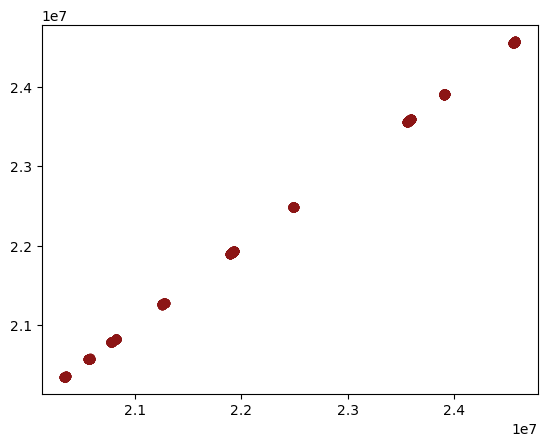

In [44]:
plt.scatter(rho_3, rho_3)

In [45]:
rover_rho = compute_pseudoranges(rover_data_gps_only)

In [141]:
sv_id = rover_data_gps_only['sv_id']
gnss_id = rover_data_gps_only['gnss_id']
gps_millis = rover_data_gps_only['gps_millis']
a = base_data_gps_only.where("sv_id", sv_id[0], "eq")
b = a.where("gnss_id", gnss_id[0], "eq")
index = np.searchsorted(base_data_gps_only['gps_millis'], rover_data_gps_only['gps_millis'][4])
index

0

In [ ]:
base_data_gps_only['sv_id']

872

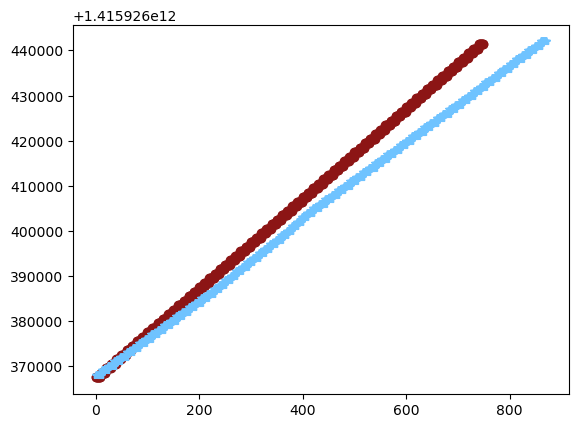

In [115]:
plt.plot(rover_data_gps_only['gps_millis'])
plt.plot(base_data_gps_only['gps_millis'])

In [113]:
base_data['gps_millis']

array([1.41592637e+12, 1.41592637e+12, 1.41592637e+12, ...,
       1.41592644e+12, 1.41592644e+12, 1.41592644e+12])

In [46]:
def compute_and_match_pr(rover_data, base_data):
    base_rho = []
    base_matched_data = []
    time_tolerance = 5000
    for i in range(len(rover_data_gps_only)):
        sv_id = rover_data['sv_id']
        gnss_id = rover_data['gnss_id']
        gps_millis = rover_data['gps_millis']
        print(f'Rover data uses sv id of {sv_id[i]}, gnss id of {gnss_id[i]}, millis of {gps_millis[i]}')
        a = base_data.where("sv_id", sv_id[i], "eq")
        b = a.where("gnss_id", gnss_id[i], "eq")
        c = b.where("gps_millis", gps_millis[i]-time_tolerance, "geq").where("gps_millis", gps_millis[i]+time_tolerance, "leq")
        rho_vals = compute_pseudoranges(c)
        try: 
            if len(rho_vals) > 0:
                rho_m = rho_vals[0]
                c_val = c.array[:, 0]
            else:
                rho_m = np.nan
                c_val = np.nan
        except:
            rho_m = rho_vals
            c_val = c.array[:, 0]
        base_rho.append(rho_m)
        base_matched_data.append(c_val)
    return base_matched_data, base_rho
matched_base_data, base_rho = compute_and_match_pr(rover_data_gps_only, base_data_gps_only)
base_rho = np.array(base_rho)

Rover data uses sv id of 2, gnss id of gps, millis of 1415926367439.0
Rover data uses sv id of 7, gnss id of gps, millis of 1415926367439.0
Rover data uses sv id of 13, gnss id of gps, millis of 1415926367439.0
Rover data uses sv id of 14, gnss id of gps, millis of 1415926367439.0
Rover data uses sv id of 15, gnss id of gps, millis of 1415926367439.0
Rover data uses sv id of 17, gnss id of gps, millis of 1415926367439.0
Rover data uses sv id of 19, gnss id of gps, millis of 1415926367439.0
Rover data uses sv id of 21, gnss id of gps, millis of 1415926367439.0
Rover data uses sv id of 22, gnss id of gps, millis of 1415926367439.0
Rover data uses sv id of 30, gnss id of gps, millis of 1415926367439.0
Rover data uses sv id of 2, gnss id of gps, millis of 1415926368439.0
Rover data uses sv id of 7, gnss id of gps, millis of 1415926368439.0
Rover data uses sv id of 13, gnss id of gps, millis of 1415926368439.0
Rover data uses sv id of 14, gnss id of gps, millis of 1415926368439.0
Rover data

TypeError: list indices must be integers or slices, not str

### Verifying that the rover is matched well to base measurements

(20000000.0, 25000000.0)

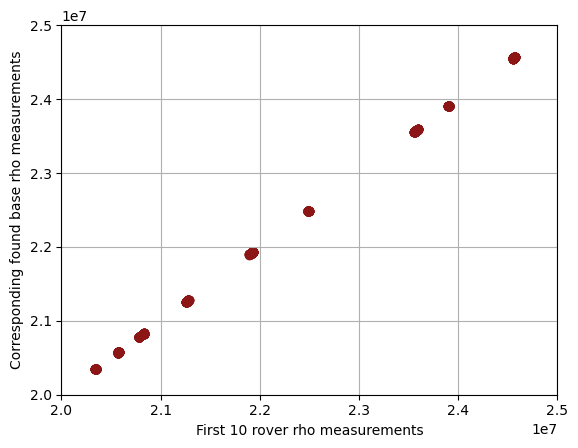

In [47]:
plt.scatter(rover_rho, base_rho)
plt.grid()
plt.xlabel('First 10 rover rho measurements')
plt.ylabel('Corresponding found base rho measurements')
plt.xlim(2e7, 2.5e7)
plt.ylim(2e7, 2.5e7)

In [94]:
len(base_rho)
timestamps = rover_data.where("gnss_id", ('gps'))['gps_millis']
satellites = rover_data.where("gnss_id", ('gps'))['sv_id']
print(f'number of unique timesteps {len(timestamps)}')

number of unique timesteps 750


In [ ]:
mat

In [74]:
np.unique(timestamps)

array([1.41592637e+12, 1.41592637e+12, 1.41592637e+12, 1.41592637e+12,
       1.41592637e+12, 1.41592637e+12, 1.41592637e+12, 1.41592637e+12,
       1.41592638e+12, 1.41592638e+12, 1.41592638e+12, 1.41592638e+12,
       1.41592638e+12, 1.41592638e+12, 1.41592638e+12, 1.41592638e+12,
       1.41592638e+12, 1.41592638e+12, 1.41592639e+12, 1.41592639e+12,
       1.41592639e+12, 1.41592639e+12, 1.41592639e+12, 1.41592639e+12,
       1.41592639e+12, 1.41592639e+12, 1.41592639e+12, 1.41592639e+12,
       1.41592640e+12, 1.41592640e+12, 1.41592640e+12, 1.41592640e+12,
       1.41592640e+12, 1.41592640e+12, 1.41592640e+12, 1.41592640e+12,
       1.41592640e+12, 1.41592640e+12, 1.41592641e+12, 1.41592641e+12,
       1.41592641e+12, 1.41592641e+12, 1.41592641e+12, 1.41592641e+12,
       1.41592641e+12, 1.41592641e+12, 1.41592641e+12, 1.41592641e+12,
       1.41592642e+12, 1.41592642e+12, 1.41592642e+12, 1.41592642e+12,
       1.41592642e+12, 1.41592642e+12, 1.41592642e+12, 1.41592642e+12,
      

### Calculate true ranges

In [50]:
BASE_STATION_LOCATION_1 = np.array([37.429711,-122.169381,25]).reshape(3, 1)
BASE_STATION_LOCATION_2 = np.array([37.4290631,-122.1723136,25]).reshape(3, 1) # multipath test

DURAND = np.array([[37.426906], [-122.173278], [21.010]]) 

In [51]:
gps_millis_column = -3
sv_id_column = 11
gnss_id_column = -13

In [52]:
matched_base_data_clean = np.zeros((len(matched_base_data),len(matched_base_data[0])))
for i in range(len(matched_base_data)):
    print(matched_base_data[i])
    matched_base_data_clean[i, :] = matched_base_data[i]
    matched_base_data_clean[i, gnss_id_column] = 100.0

[ 0.00000000e+00  1.73189115e+12  2.56590199e+10  1.80000000e+01
             nan -1.41592634e+18  0.00000000e+00  1.03855247e+01
             nan             nan  4.19510000e+04  2.00000000e+00
  0.00000000e+00  1.63990000e+04  8.95679203e+13  1.30000000e+01
  3.52099991e+01  1.19668510e+02  9.76562500e-02  1.70000000e+01
 -1.16667323e+04  1.64199561e-01  1.57542003e+09             nan
             nan             nan  0.00000000e+00             nan
  0.00000000e+00  5.19999981e+00  3.20000000e+01 -1.76951289e+01
             nan -1.76951289e+01             nan  0.00000000e+00
  4.01536633e+14  1.00000000e+00  0.00000000e+00  1.41592637e+12
  2.39012781e+07  3.89730195e+00]
[ 0.00000000e+00  1.73189115e+12  2.56590199e+10  1.80000000e+01
             nan -1.41592634e+18  0.00000000e+00  1.03855247e+01
             nan             nan  4.19510000e+04  7.00000000e+00
  0.00000000e+00  1.63910000e+04  8.95679214e+13  1.50000000e+01
  3.20099983e+01  5.59765259e+02  1.20563284e-01  1.6000

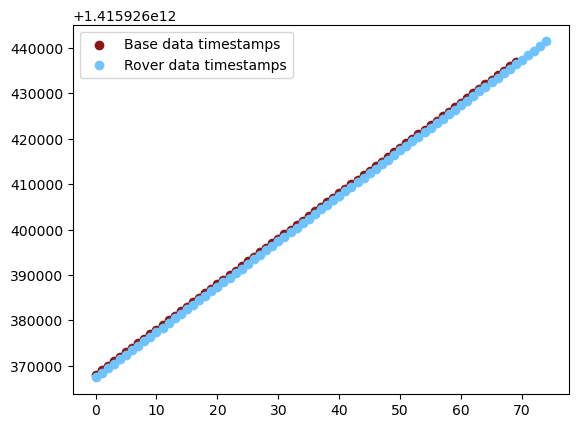

In [98]:
plt.scatter(np.arange(71), np.unique(matched_base_data_clean[:, gps_millis_column]), label='Base data timestamps')
plt.scatter(np.arange(75), np.unique(timestamps), label='Rover data timestamps')
plt.legend()

In [53]:
# TODO: DEAL WITH THESE BOIS
np.where(np.isnan(matched_base_data_clean[:, gps_millis_column]) == True)[0]

array([241, 251, 261, 271, 281, 291, 301])

In [54]:
## Load the RinexNav data for that day
rinex_nav_paths = glp.load_ephemeris(
    "rinex_nav",
    np.array(np.nanmin(matched_base_data_clean[:, gps_millis_column]),np.nanmax(matched_base_data_clean[:, gps_millis_column])),
    verbose=True,
)
rinex_nav = glp.RinexNav(rinex_nav_paths, verbose=True)

ephemeris dates needed: [datetime.date(2024, 11, 17), datetime.date(2024, 11, 18)]
using previously downloaded file:
 /Users/thomashuang/school/AA 272/final/dgnss_aa272/data/ephemeris/rinex/nav/BRDM00DLR_S_20243220000_01D_MN.rnx
using previously downloaded file:
 /Users/thomashuang/school/AA 272/final/dgnss_aa272/data/ephemeris/rinex/nav/BRDM00DLR_S_20243230000_01D_MN.rnx
using previously downloaded file:
 /Users/thomashuang/school/AA 272/final/dgnss_aa272/data/ephemeris/rinex/nav/BRDM00DLR_S_20243220000_01D_MN.rnx
using previously downloaded file:
 /Users/thomashuang/school/AA 272/final/dgnss_aa272/data/ephemeris/rinex/nav/BRDM00DLR_S_20243230000_01D_MN.rnx


In [55]:
GNSS_ID_FLOAT = 100.0
def find_sv_pos(rinex, sv_id, gnss_id, gps_millis):
    """ finding sv position with ephemeris data FOR DURAND receiver"""
    n = len(sv_id)
    position_info = np.zeros((n, 3))
    for i in range(n):
        sv_at_millis = glp.find_sv_states(gps_millis[i], rinex)
        cropped_sv_at_millis = sv_at_millis.where('sv_id', sv_id[i], 'eq')
        gnss_id_at_millis = cropped_sv_at_millis.where('gnss_id', ('gps'), 'eq')
        # TODO: JANK PLS FIX AND DO SOMETHING SMARTER
        position_info[i, 0] = np.mean(gnss_id_at_millis['x_sv_m'])
        position_info[i, 1] = np.mean(gnss_id_at_millis['y_sv_m'])
        position_info[i, 2] = np.mean(gnss_id_at_millis['z_sv_m'])
    return position_info

# FOR DURAND DATA
# def get_measured_pseudorange(df,sv_id):
#     """ get measured pseudorange of specific sv for durand receiver"""
#     filtered_df = df[df.iloc[:,4] == str(sv_id)]
#     return filtered_df.iloc[:,14]

def distance_to_groundtruth(sv_pos, ground_truth):
    """ calculate ground truth distance from SV to Durand receiver"""
    gt_ecef = glp.geodetic_to_ecef(ground_truth)
    distance = np.linalg.norm(sv_pos[:, :, None] - gt_ecef[None, :, :], axis=1)
    return distance

def correction(true_range, base_pseudorange, rover_pseudorange):
    """ true_range: ground truth distance from distance_to_groundtruth function
    base_pseudorange: pseudorange for base station
    pseudorange: pseudorange for phone """
    e = true_range - base_pseudorange
    adjusted_pseudorange = rover_pseudorange + e
    return adjusted_pseudorange



# def get_pseudorange(raw_data, sv_id):
#     """ get measure pseudorange of the rover with specified sv_id"""
#     cropped_data = raw_data.where("sv_id", sv_id, "eq")
#     pseudorange = compute_pseudoranges(cropped_data)
#     return pseudorange

In [97]:
print(np.unique(matched_base_data_clean[:, sv_id_column]))
print(np.unique(satellites))

[ 2.  7. 13. 14. 15. 17. 19. 21. 22. 30. nan]
[ 2  7 13 14 15 17 19 21 22 30]


In [56]:

sv_pos = find_sv_pos(rinex_nav, matched_base_data_clean[:, sv_id_column], matched_base_data_clean[:, gnss_id_column], matched_base_data_clean[:, gps_millis_column])

# sv_pos = find_sv_pos(rover_ephemeris, 6)
# true_ranges = distance_to_groundtruth()

/Users/thomashuang/anaconda3/lib/python3.11/site-packages/gnss_lib_py/utils/time_conversions.py:119: RuntimeWarning:

invalid value encountered in cast

/Users/thomashuang/anaconda3/lib/python3.11/site-packages/gnss_lib_py/navdata/navdata.py:294: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/Users/thomashuang/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/Users/thomashuang/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning:

invalid value encountered in scalar divide



### Actual dGNSS shit

In [57]:
# base_pseudorange_unmatched = compute_pseudoranges(base_data_gps_only)
true_range = distance_to_groundtruth(sv_pos, BASE_STATION_LOCATION_1).flatten()
# rover_pseudorange = compute_pseudoranges(rover_data_gps_only)
corrected_pseudorange = correction(true_range, base_rho, rover_rho)

## are we matching rover and base SVs

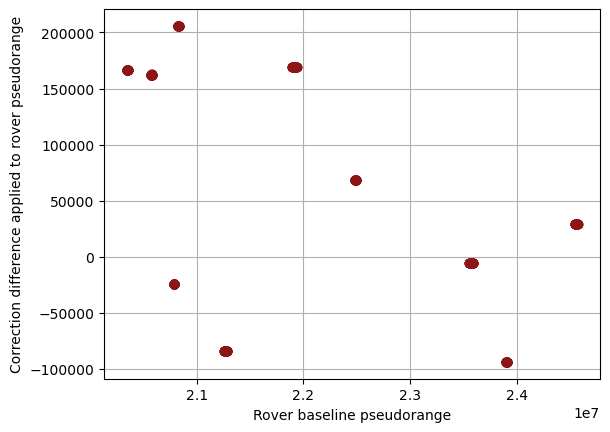

In [58]:
plt.scatter(rover_rho, corrected_pseudorange - rover_rho)
plt.xlabel('Rover baseline pseudorange')
plt.ylabel('Correction difference applied to rover pseudorange')
plt.grid()

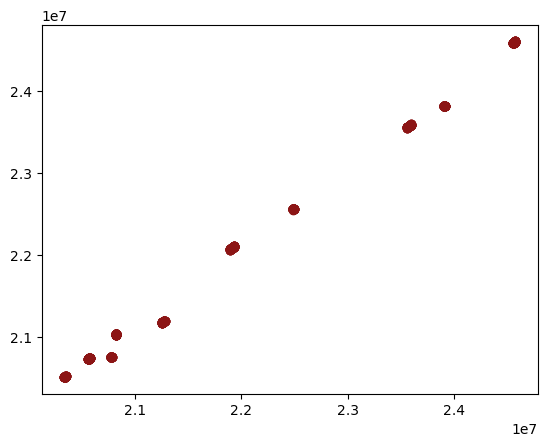

In [59]:
plt.scatter(rover_rho, corrected_pseudorange)

### Newton Raphson to solve for position

In [60]:
# # Define four arrays

# x = sv_pos[:40, 0]
# y = sv_pos[:40, 1]
# z = sv_pos[:40, 2]

# # Create DataFrame using the arrays
# df = pd.DataFrame({
#     'x_sv_m': x,
#     'y_sv_m': y,
#     'z_sv_m': z,
#     'corr_pr_m': corrected_pseudorange[:40]
# })

# # Create DataFrame using the arrays
# df_raw = pd.DataFrame({
#     'x_sv_m': x,
#     'y_sv_m': y,
#     'z_sv_m': z,
#     'corr_pr_m': rover_rho[:40]
# })

# # Create DataFrame using the arrays
# df_base = pd.DataFrame({
#     'x_sv_m': x,
#     'y_sv_m': y,
#     'z_sv_m': z,
#     'corr_pr_m': base_rho[:40]
# })

In [61]:
import numpy as np
import pandas as pd

def newton_raphson(x0, bu_0, max_iterations, dataset):
    """
    Function description: perform newton raphson to compute position of observer based on available satellite
    data, stop function when we have updates in delta_x, delta_bu that are less than a centimeter,
    or hit maximum number of iterations

    Inputs:
    1) x_0: initial guess for position
    2) bu_0: initial guess for clock bias
    3) max_iterations: maximum number of iterations until covergence
    4) dataset_name: name of file to read in

    return: 
    1) optimized position
    2) optimized clock bias
    3) number of iterations until covergence
    """
    x_est = x0
    b_est = bu_0


    for i in range(max_iterations):

        # Get Geometry Matrix and deltas for rho
        geometry_matrix = []
        delta_rho = []
        for index, sat in dataset.iterrows():
            geometry_matrix.append(get_geometry_row(x_est, sat['x_sv_m'], sat['y_sv_m'], sat['z_sv_m']))
            delta_rho.append(sat['corr_pr_m'] - get_theoretical_pseudoranges(x_est, b_est, sat['x_sv_m'], sat['y_sv_m'], sat['z_sv_m']))

        # Convert into matricies to make it easier to use numpy functions
        geometry_matrix = np.array(geometry_matrix)
        delta_rho = np.array(delta_rho)

        # Update the deltas
        delta_x, delta_bu = newton_raphson_step(geometry_matrix, delta_rho)
        x_est = np.add(x_est, delta_x)
        b_est = b_est + delta_bu
    
        if True: #i%10 == 0:
            print("round: ",i+1)
            print("x_est: ", x_est)
            print("b_est: ", b_est)

        if delta_x[0] < 0.01 and delta_x[1] < 0.01 and delta_x[2] < 0.01 and delta_bu < 0.01:
            break
    
    
    print("round: ",i+1)
    print("FINAL - x_est: ", x_est)
    print("FINAL - b_est: ", b_est)
    return x_est


def get_geometry_row(x_est, x_sv_m, y_sv_m, z_sv_m):
    """
    Function description: Compute each row for the geometry matrix given a satellite position and
    current guess for position estimate

    Inputs:
    1) x_est: current guess for current position estimate 
    2) x_sv_m: a set for satellite position x
    3) y_sv_m: a set for satellite position y
    4) z_sv_m: a set for satellite position z


    return: 
    1) Geometry Matrix G (first 3 columns unit vector)
    """

    x = x_sv_m - x_est[0]
    y = y_sv_m - x_est[1]
    z = z_sv_m - x_est[2]

    magnitude = np.sqrt((x)**2 + (y)**2 + (z)**2)

    return ([-x/magnitude, -y/magnitude, -z/magnitude, 1])



def get_theoretical_pseudoranges(x_est, b_est, x_sv_m, y_sv_m, z_sv_m):
    """
    Function description: Compute each row for the geometry matrix given a satellite position and
    current guess for position estimate

    Inputs:
    1) x_est: current position estimate 
    2) b_est: current clock bias estimate 
    3) x_sv_m: a set for satellite position x
    4) y_sv_m: a set for satellite position y
    5) z_sv_m: a set for satellite position z

    return: 
    1) Theoretical pseudorange measurement vector
    """


    x = x_sv_m - x_est[0]
    y = y_sv_m - x_est[1]
    z = z_sv_m - x_est[2]

    magnitude = np.sqrt((x)**2 + (y)**2 + (z)**2)
    b_k = 0 # assume its zero for all satellites, already corrrected for in data

    return magnitude + b_est - b_k

def newton_raphson_step(G,delta_rho):
    """
    Function description: Take one step of newton-raphson optimization, compute update of 
    delta_x and delta_bu

    Input:
    1) G: geometry matrix
    2) delta_rho: difference of theoretical and measured pseudoranges 

    return:
    1) delta_x
    2) delta_bu
    """
    G_t = G.transpose()
    deltas = np.matmul(np.matmul(np.linalg.inv(np.matmul(G_t, G)),G_t),delta_rho)

    delta_x = deltas[0:3]
    delta_bu = deltas[3]

    return delta_x, delta_bu

In [62]:
unique_timestamps = np.unique(timestamps)

pos_ls = []
# batch pr with same millis
for i in range(len(unique_timestamps)):
    mask = timestamps == unique_timestamps[i]
    pr = corrected_pseudorange[mask]
    x = sv_pos[mask, 0]
    y = sv_pos[mask, 1]
    z = sv_pos[mask, 2]

    # Create DataFrame using the arrays
    df = pd.DataFrame({
        'x_sv_m': x,
        'y_sv_m': y,
        'z_sv_m': z,
        'corr_pr_m': pr
    })

    df_cleaned = df.dropna()
    pos = newton_raphson([0,0,0],0,30,df_cleaned)

    print("Lat/Long Version: ",glp.ecef_to_geodetic(pos))

    pos_ls.append(glp.ecef_to_geodetic(pos))

pos_array = np.array(pos_ls)
dgnss = glp.NavData()
dgnss['lat_dgnss_deg'] = pos_array[:,:,0]
dgnss['lon_rx_gnss_deg'] = pos_array[:,:,1]

    

round:  1
x_est:  [-3190025.31076397 -5150302.96985889  4662474.65111533]
b_est:  1319669.6845063448
round:  2
x_est:  [-2712839.59225605 -4320305.2573447   3883556.36142507]
b_est:  45330.65534737054
round:  3
x_est:  [-2699828.44159199 -4292714.84376744  3855493.95592135]
b_est:  38.046480639597576
round:  4
x_est:  [-2699816.10679446 -4292683.60014025  3855460.34706959]
b_est:  -12.58896481752646
round:  5
x_est:  [-2699816.10676948 -4292683.6001106   3855460.34698509]
b_est:  -12.589043716255873
round:  5
FINAL - x_est:  [-2699816.10676948 -4292683.6001106   3855460.34698509]
FINAL - b_est:  -12.589043716255873
Lat/Long Version:  [[  37.43057027 -122.16719701   20.52455104]]
round:  1
x_est:  [-3190403.05680501 -5150188.36801497  4662337.29509517]
b_est:  1319692.2901859398
round:  2
x_est:  [-2713175.77154871 -4320230.49475397  3883434.40565828]
b_est:  45369.23606679798
round:  3
x_est:  [-2700164.2836764  -4292641.48810923  3855376.98565882]
b_est:  79.96743807260646
round:  4
x

In [63]:
raw_ls = []
# batch pr with same millis
for i in range(len(unique_timestamps)):
    mask = timestamps == unique_timestamps[i]
    pr = rover_rho[mask]
    x = sv_pos[mask, 0]
    y = sv_pos[mask, 1]
    z = sv_pos[mask, 2]

    # Create DataFrame using the arrays
    df = pd.DataFrame({
        'x_sv_m': x,
        'y_sv_m': y,
        'z_sv_m': z,
        'corr_pr_m': pr
    })

    df_cleaned = df.dropna()
    pos = newton_raphson([0,0,0],0,30,df_cleaned)

    print("Lat/Long Version: ",glp.ecef_to_geodetic(pos))

    raw_ls.append(glp.ecef_to_geodetic(pos))

raw_array = np.array(raw_ls)
rover = glp.NavData()
rover['lat_rover_deg'] = raw_array[:,:,0]
rover['lon_rover_deg'] = raw_array[:,:,1]

round:  1
x_est:  [-3330540.04906239 -5156925.90181043  4661050.74601563]
b_est:  1290886.3328914496
round:  2
x_est:  [-2836793.06290184 -4329634.47943041  3881934.73380611]
b_est:  6908.519366623834
round:  3
x_est:  [-2822908.99324677 -4301558.83700069  3853667.45496605]
b_est:  -38981.95154152012
round:  4
x_est:  [-2822878.55595666 -4301509.08663613  3853621.34032564]
b_est:  -39050.054220015554
round:  5
x_est:  [-2822878.51818407 -4301509.04354536  3853621.32455576]
b_est:  -39050.08725004669
round:  6
x_est:  [-2822878.51812714 -4301509.04349669  3853621.3245665 ]
b_est:  -39050.08727739885
round:  6
FINAL - x_est:  [-2822878.51812714 -4301509.04349669  3853621.3245665 ]
FINAL - b_est:  -39050.08727739885
Lat/Long Version:  [[ 3.70161832e+01 -1.23275011e+02  5.77934296e+04]]
round:  1
x_est:  [-3330917.79510342 -5156811.29996651  4660913.38999547]
b_est:  1290908.9385710454
round:  2
x_est:  [-2837130.24299591 -4329562.72138087  3881812.2735948 ]
b_est:  6947.15988458856
round:

In [64]:
base_ls = []
# batch pr with same millis
for i in range(len(unique_timestamps)):
    mask = timestamps == unique_timestamps[i]
    pr = base_rho[mask]
    x = sv_pos[mask, 0]
    y = sv_pos[mask, 1]
    z = sv_pos[mask, 2]

    # Create DataFrame using the arrays
    df = pd.DataFrame({
        'x_sv_m': x,
        'y_sv_m': y,
        'z_sv_m': z,
        'corr_pr_m': pr
    })

    df_cleaned = df.dropna()
    pos = newton_raphson([0,0,0],0,30,df_cleaned)

    print("Lat/Long Version: ",glp.ecef_to_geodetic(pos))

    base_ls.append(glp.ecef_to_geodetic(pos))

base_array = np.array(base_ls)
base = glp.NavData()
base['lat_base_deg'] = base_array[:,:,0]
base['lon_base_deg'] = base_array[:,:,1]

round:  1
x_est:  [-3330759.85640495 -5156847.35342592  4660962.24327084]
b_est:  1290882.736089021
round:  2
x_est:  [-2836990.17215512 -4329584.46068325  3881858.48335245]
b_est:  6918.956756891217
round:  3
x_est:  [-2823105.98589166 -4301509.73809983  3853594.34443036]
b_est:  -38969.231902034946
round:  4
x_est:  [-2823075.55137709 -4301459.97405999  3853548.2875266 ]
b_est:  -39037.31436137066
round:  5
x_est:  [-2823075.5135496  -4301459.93099223  3853548.27192497]
b_est:  -39037.34731761461
round:  6
x_est:  [-2823075.51349247 -4301459.93094344  3853548.27193602]
b_est:  -39037.34734492229
round:  6
FINAL - x_est:  [-2823075.51349247 -4301459.93094344  3853548.27193602]
FINAL - b_est:  -39037.34734492229
Lat/Long Version:  [[ 3.70153020e+01 -1.23277145e+02  5.78029679e+04]]
round:  1
x_est:  [-3330759.85640495 -5156847.35342592  4660962.24327084]
b_est:  1290882.736089021
round:  2
x_est:  [-2836990.17215512 -4329584.46068325  3881858.48335245]
b_est:  6918.956756891217
round: 

In [69]:
ls = []
ls.append(dgnss)
ls.append(base)
ls.append(rover)

a = []
a.append(base)
a.append(rover)
glp.plot_map(*a)


In [31]:
import gnss_lib_py as glp

df_cleaned = df.dropna()
x = newton_raphson([0,0,0],0,30,df_cleaned)

print("Lat/Long Version: ",glp.ecef_to_geodetic(x))

round:  1
x_est:  [-3190100.15422173 -5147184.16976572  4658358.67329628]
b_est:  1315929.216040205
round:  2
x_est:  [-2714367.90852689 -4319746.65187758  3882707.16072866]
b_est:  45170.06118321698
round:  3
x_est:  [-2701522.7394076  -4292421.43809482  3855025.83023775]
b_est:  344.4121323856525
round:  4
x_est:  [-2701510.83020376 -4292390.82048783  3854993.62076125]
b_est:  295.20738361373776
round:  5
x_est:  [-2701510.83027761 -4292390.8203915   3854993.62108099]
b_est:  295.207453602573
round:  5
FINAL - x_est:  [-2701510.83027761 -4292390.8203915   3854993.62108099]
FINAL - b_est:  295.207453602573
Lat/Long Version:  [[  37.42364596 -122.18516439  256.76129846]]


In [32]:
import gnss_lib_py as glp

df_raw_cleaned = df_raw.dropna()
x_raw = newton_raphson([0,0,0],0,30,df_raw_cleaned)

print("Lat/Long Version: ",glp.ecef_to_geodetic(x_raw))

round:  1
x_est:  [-3331102.56050596 -5156745.74971478  4660837.69408665]
b_est:  1290909.065949243
round:  2
x_est:  [-2837296.10775567 -4329521.40770541  3881746.42641187]
b_est:  6959.106791943312
round:  3
x_est:  [-2823411.6087887  -4301447.76734281  3853487.21774694]
b_est:  -38925.9726407336
round:  4
x_est:  [-2823381.17963354 -4301397.98426988  3853441.26556738]
b_est:  -38994.0164487304
round:  5
x_est:  [-2823381.1417137  -4301397.94125218  3853441.25026852]
b_est:  -38994.04926704056
round:  6
x_est:  [-2823381.14165622 -4301397.94120321  3853441.25028011]
b_est:  -38994.04929426527
round:  6
FINAL - x_est:  [-2823381.14165622 -4301397.94120321  3853441.25028011]
FINAL - b_est:  -38994.04929426527
Lat/Long Version:  [[ 3.70139160e+01 -1.23280369e+02  5.78310654e+04]]


In [33]:
import gnss_lib_py as glp

df_base_cleaned = df_base.dropna()
x_base = newton_raphson([0,0,0],0,30,df_base_cleaned)

print("Lat/Long Version: ",glp.ecef_to_geodetic(x_base))

round:  1
x_est:  [-3330759.85640497 -5156847.35342586  4660962.24327084]
b_est:  1290882.7360890005
round:  2
x_est:  [-2836990.17215512 -4329584.46068325  3881858.48335244]
b_est:  6918.956756883999
round:  3
x_est:  [-2823105.98589166 -4301509.73809983  3853594.34443035]
b_est:  -38969.23190203698
round:  4
x_est:  [-2823075.55137709 -4301459.97405999  3853548.2875266 ]
b_est:  -39037.31436136679
round:  5
x_est:  [-2823075.5135496  -4301459.93099223  3853548.27192497]
b_est:  -39037.34731761092
round:  6
x_est:  [-2823075.51349247 -4301459.93094344  3853548.27193602]
b_est:  -39037.34734492072
round:  6
FINAL - x_est:  [-2823075.51349247 -4301459.93094344  3853548.27193602]
FINAL - b_est:  -39037.34734492072
Lat/Long Version:  [[ 3.70153020e+01 -1.23277145e+02  5.78029679e+04]]
